In [ ]:
"""
This notebook performs the following tasks:
1. Downloads NOAA climate data by station.
2. Preprocesses the downloaded data to prepare it for analysis.

Author: Espoir
"""

In [1]:
import os
import requests
from bs4 import BeautifulSoup
import pandas as pd
from tqdm import tqdm
import gzip
import shutil
import warnings as ws
ws.filterwarnings(action='ignore')

In [3]:
os.chdir(r'G:\Master_DJAMAN\Database')


1) First go to https://www.ncei.noaa.gov/cdo-web/datasets
2) Click on the FTP option ====> https://www.ncei.noaa.gov/pub/data/ghcn/daily/
3) Then download these files (see figure below)  
Metadata are more explained here: https://www.ncei.noaa.gov/pub/data/cdo/documentation/GHCND_documentation.pdf


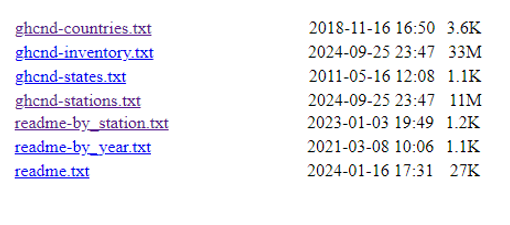

#### Downloading process

In [3]:
### Files needed: ghcnd-stations , readme on NOAA to check the stations code
"""
This script downloads and decompresses climate data files from the NOAA website. 
This code was designed for Quebec, need to improve it to make it general function to download  for others stations
The script performs the following steps:
1. Defines the base URL for the NOAA climate data.
2. Fetches the content of the web directory at the base URL.
3. Parses the HTML content to find all links that start with 'CA007'.
4. Creates a directory named 'CA007_files' to store the downloaded files.
5. Downloads and decompresses each file.
"""

# Define the base URL
base_url = 'https://www.ncei.noaa.gov/pub/data/ghcn/daily/by_station/'

# Fetch the content of the web directory
response = requests.get(base_url)
response.raise_for_status()  # Ensure we notice bad responses

# Parse the HTML content
soup = BeautifulSoup(response.text, 'html.parser')

station_code = 'CA007'
# Find all links that start with 'CA007'
links = soup.find_all('a')
file_links = [link.get('href') for link in links if link.get('href').startswith(station_code)]

# Create a directory to store the downloaded files
os.makedirs(f'{station_code}_files', exist_ok=True)

print(f"Total files to download: {len(file_links)}\n")

# Download and decompress each file with a progress indicator using tqdm
for file_link in tqdm(file_links, desc="Downloading and decompressing files", unit="file"):
    file_url = base_url + file_link
    file_response = requests.get(file_url)
    file_response.raise_for_status()  # Ensure we notice bad responses
    
    # Define the path for the compressed file and the decompressed file
    compressed_file_path = os.path.join(f'{station_code}_files', file_link)
    decompressed_file_path = os.path.splitext(compressed_file_path)[0]  # Remove .gz extension
    
    # Save the compressed file
    with open(compressed_file_path, 'wb') as compressed_file:
        compressed_file.write(file_response.content)
    
    # Decompress the file
    with gzip.open(compressed_file_path, 'rb') as f_in:
        with open(decompressed_file_path, 'wb') as f_out:
            shutil.copyfileobj(f_in, f_out)
    
    # Remove the compressed file after decompressing
    os.remove(compressed_file_path)



Total files to download: 949

Progress: [==================================================] 949/949
All files downloaded and decompressed.


#### Preprocessing

In [23]:

# Define the station code
station_code = "CA007"  # Replace with your station code or pass it as a variable

# Define the directory containing the station_code files
directory = os.path.join(os.getcwd(), f"{station_code}_files")

# Check if the output file already exists and ask if it should be overwritten
output_file = f'processed_{station_code}_data.csv'
if os.path.exists(output_file):
    overwrite = input(f"File '{output_file}' already exists. Overwrite? (y/n): ").strip().lower()
    if overwrite != 'y':
        print("Process aborted. No file was overwritten.")
        exit()

# Initialize an empty DataFrame to store all processed data
all_data = pd.DataFrame()

# Iterate over each file in the directory with a progress bar
file_list = [f for f in os.listdir(directory) if f.startswith(station_code) and f.endswith('.csv')]
for filename in tqdm(file_list, desc="Processing files", unit="file"):
    # Define the full path to the CSV file
    file_path = os.path.join(directory, filename)
    try:
        # Read the file into a DataFrame
        df = pd.read_csv(file_path, header=None, names=['Station', 'Date', 'Variable', 'Value', "C1", "C2", "C3", "C4"],
                         dtype={'Station': str, 'Date': str, 'Variable': str, 'Value': str})
        
        # Filter out rows where the Date column is not valid
        df = df[df['Date'].str.isdigit()]
        
        # Extract year, month, day from the Date column
        df['Year'] = df['Date'].str[:4]
        df['Month'] = df['Date'].str[4:6]
        df['Day'] = df['Date'].str[6:8]
        
        # Convert Date column to proper date format
        df['Date'] = pd.to_datetime(df['Date'], format='%Y%m%d').dt.strftime('%Y/%m/%d')
        
        # Convert the Value column to numeric, setting errors='coerce' will replace invalid parsing with NaN
        df['Value'] = pd.to_numeric(df['Value'], errors='coerce')
        
        # Pivot the DataFrame to have variables as columns
        df_pivot = df.pivot(index=['Station', 'Date', 'Year', 'Month', 'Day'], columns='Variable', values='Value').reset_index()
        
        # Append the processed DataFrame to the all_data DataFrame
        all_data = pd.concat([all_data, df_pivot], ignore_index=True)
    
    except Exception as e:
        print(f"Error processing file {filename}: {e}")

# Save the combined and processed data to a CSV file
all_data.to_csv(output_file, index=False)
print(f"\nData processing complete. File saved as '{output_file}'.")


Processing files: 100%|██████████| 949/949 [48:36<00:00,  3.07s/file]



Data processing complete. File saved as 'processed_CA007_data.csv'.


In [2]:
os.chdir(r'G:\Master_DJAMAN\Database')

In [3]:
df_station = pd.read_fwf("ghcnd-stations.txt", 
                 widths=[12, 9, 9, 7, 29, 9, 12],  
                 names=['Station', 'Latitude', 'Longitude', 'Altitude', 'StationName', 'Type', 'Code'])  # Adjust column names
df_station.sample(5)

,Station,Latitude,Longitude,Altitude,StationName,Type,Code
97306,US1WVBY0002,39.5875,-77.9181,149.4,WV FALLING WATERS 2.4 NW,NaN,NaN
72100,US1MDCV0022,38.3809,-76.4051,35.1,MD LUSBY 2.4 NE,NaN,NaN
18565,BR001448000,-14.1500,-48.0800,0.0,COLINAS DO SUL,NaN,NaN
10672,ASN00055226,-30.7833,149.8833,-999.9,BLAIRMORE 1,NaN,NaN
92607,US1TXMDL033,32.0253,-102.1357,859.5,TX MIDLAND 2.1 W,NaN,NaN


In [5]:
#  USE THIS CODE IF YOU DON'T FACE WITH MEMORY ISSUE
# data = pd.read_csv('processed_CA007_data.csv')
# # Set the 'Station' column as the index for both DataFrames
# df_station.set_index('Station', inplace=True)
# data.set_index('Station', inplace=True)

# # Join the DataFrames
# data = data.join(df_station, how='left')

# # Reset index if you want to keep 'Station' as a column
# data.reset_index(inplace=True)


In [4]:

df_station.set_index('Station', inplace=True)

# Process large file in chunks
chunk_size = 100000  # Adjust based on memory capacity
data_chunks = []  # List to hold processed chunks

# Read the large CSV in chunks
for chunk in pd.read_csv('processed_CA007_data.csv', chunksize=chunk_size):
    # Set index and join with df_station
    chunk.set_index('Station', inplace=True)
    chunk = chunk.join(df_station, how='left')
    chunk.reset_index(inplace=True)  # Reset index to keep 'Station' as a column
    
    # Append processed chunk to the list
    data_chunks.append(chunk)

# Concatenate all chunks
data = pd.concat(data_chunks, ignore_index=True)


In [6]:
data.columns

Index(['Station', 'Date', 'Year', 'Month', 'Day', 'MDPR', 'MDSF', 'PRCP',
       'SNOW', 'TMAX', 'TMIN', 'TAVG', 'WDFG', 'WSFG', 'SNWD', 'PGTM', 'WT01',
       'WT03', 'WT04', 'WT06', 'WT08', 'WT09', 'WT16', 'WT18', 'Latitude',
       'Longitude', 'Altitude', 'StationName', 'Type', 'Code'],
      dtype='object')

In [7]:
data = data.drop(columns=['MDPR', 'MDSF', 'WDFG', 'WSFG', 'SNWD', 'PGTM', 'WT01',
       'WT03', 'WT04', 'WT06', 'WT08', 'WT09', 'WT16', 'WT18', 'Type', 'Code']) 
data.sample(5) 

,Station,Date,Year,Month,Day,PRCP,SNOW,TMAX,TMIN,TAVG,Latitude,Longitude,Altitude,StationName
7331752,CA007060400,1997/05/05,1997,5,5,0.0,0.0,117.0,-35.0,29.0,48.3333,-71.0000,159.0,QC BAGOTVILLE A
1482906,CA007021840,2014/11/21,2014,11,21,0.0,0.0,-55.0,-95.0,NaN,45.1500,-71.8000,259.0,QC COATICOOK
4424690,CA007035360,1961/05/28,1961,5,28,0.0,0.0,NaN,NaN,NaN,45.9167,-74.2667,290.0,QC MORIN HEIGHTS
5609901,CA007048421,1980/07/20,1980,7,20,0.0,0.0,172.0,89.0,NaN,50.7000,-59.3167,9.0,QC TETE A LA BALEINE
4833304,CA007040440,1999/08/27,1999,8,27,0.0,0.0,215.0,128.0,NaN,49.1333,-68.2000,22.0,QC BAIE-COMEAU A


In [8]:
from geopy.geocoders import Nominatim

# Define function to get region from coordinates
def get_region(lat, lng):
    geolocator = Nominatim(user_agent="my_geocoder")
    location = geolocator.reverse((lat, lng), language="en", exactly_one=True)
    if location:
        address = location.raw.get('address', {})
        region = address.get('region', address.get('state_district', "Region Not Found"))
        return region
    return "Region Not Found"


In [9]:
# Get unique combinations of LATITUDE, LONGITUDE, and StationName based on unique 
unique_coords = data[['Latitude', 'Longitude']].drop_duplicates()
unique_coords['Region'] = unique_coords.apply(lambda row: get_region(row['Latitude'], row['Longitude']), axis=1)


In [16]:
unique_coords.sample(10)

,Latitude,Longitude,Region
2199849,45.3333,-71.4000,Estrie
7157332,48.1333,-68.4833,Bas-Saint-Laurent
7372918,48.9000,-71.7667,Saguenay–Lac-Saint-Jean
1318322,45.2500,-72.8500,Estrie
937481,46.3667,-72.8000,Mauricie
4897048,49.2333,-68.1833,Côte-Nord
1521353,45.9167,-71.3167,Chaudière-Appalaches
3628283,46.1000,-71.3500,Chaudière-Appalaches
8116858,47.9000,-73.8000,Mauricie
5517331,47.5667,-70.5500,Capitale-Nationale


In [35]:
#Check the name of region in unique_coords and correct if necessary
#You can use https://qualificationsquebec.com/le-quebec-et-ses-regions/ to correct it
# unique_coords['Region'].unique()
#Use rename method to correct name of region if needed

In [27]:
# Merge the data and unique_coords based on Latitude and Longitude
data = pd.merge(data, unique_coords, on=['Latitude', 'Longitude'], how='left')

In [28]:
#Check for example for Capitale-Nationale
data[data.Region == "Capitale-Nationale"]

,Station,Date,Year,Month,Day,PRCP,SNOW,TMAX,TMIN,TAVG,Latitude,Longitude,Altitude,StationName,Region
5517331,CA007047770,1957/06/01,1957,6,1,0.0,0.0,283.0,78.0,NaN,47.5667,-70.55,91.0,QC ST URBAIN,Capitale-Nationale
5517332,CA007047770,1957/06/02,1957,6,2,201.0,0.0,178.0,83.0,NaN,47.5667,-70.55,91.0,QC ST URBAIN,Capitale-Nationale
5517333,CA007047770,1957/06/03,1957,6,3,8.0,0.0,178.0,6.0,NaN,47.5667,-70.55,91.0,QC ST URBAIN,Capitale-Nationale
5517334,CA007047770,1957/06/04,1957,6,4,0.0,0.0,211.0,56.0,NaN,47.5667,-70.55,91.0,QC ST URBAIN,Capitale-Nationale
5517335,CA007047770,1957/06/05,1957,6,5,0.0,0.0,156.0,-6.0,NaN,47.5667,-70.55,91.0,QC ST URBAIN,Capitale-Nationale
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5532944,CA007047770,2004/04/26,2004,4,26,0.0,0.0,40.0,-10.0,NaN,47.5667,-70.55,91.0,QC ST URBAIN,Capitale-Nationale
5532945,CA007047770,2004/04/27,2004,4,27,0.0,0.0,110.0,10.0,NaN,47.5667,-70.55,91.0,QC ST URBAIN,Capitale-Nationale
5532946,CA007047770,2004/04/28,2004,4,28,0.0,0.0,75.0,0.0,NaN,47.5667,-70.55,91.0,QC ST URBAIN,Capitale-Nationale
5532947,CA007047770,2004/04/29,2004,4,29,0.0,0.0,220.0,-30.0,NaN,47.5667,-70.55,91.0,QC ST URBAIN,Capitale-Nationale


In [29]:
# List of regions in Quebec # Get fro
regions = ['Capitale-Nationale', 'Lanaudière', 'Mauricie', 'Montérégie', 'Laurentides', 
           'Chaudière-Appalaches', 'Centre-du-Québec', 'Estrie', 'Region Not Found', 
           'Montreal (administrative region)', 'Outaouais', 'Côte-Nord', 'Saguenay–Lac-Saint-Jean', 
           'Bas-Saint-Laurent', 'Gaspésie–Îles-de-la-Madeleine', 'Abitibi-Témiscamingue', 'Nord-du-Québec', 'Labrador']

In [30]:
# Iterate over each region and export corresponding subset to CSV
#As file data is huge I prefere split it by each region so i can easily apply further data analysis
for region in regions:
    subset_data = data[data['Region'] == region]
    output_csv_path = f'subset_data_{region}.csv'
    subset_data.to_csv(output_csv_path, index=False)
    print(f"Subset data for {region} saved to: {output_csv_path}")

Subset data for Capitale-Nationale saved to: subset_data_Capitale-Nationale.csv
Subset data for Lanaudière saved to: subset_data_Lanaudière.csv
Subset data for Mauricie saved to: subset_data_Mauricie.csv
Subset data for Montérégie saved to: subset_data_Montérégie.csv
Subset data for Laurentides saved to: subset_data_Laurentides.csv
Subset data for Chaudière-Appalaches saved to: subset_data_Chaudière-Appalaches.csv
Subset data for Centre-du-Québec saved to: subset_data_Centre-du-Québec.csv
Subset data for Estrie saved to: subset_data_Estrie.csv
Subset data for Region Not Found saved to: subset_data_Region Not Found.csv
Subset data for Montreal (administrative region) saved to: subset_data_Montreal (administrative region).csv
Subset data for Outaouais saved to: subset_data_Outaouais.csv
Subset data for Côte-Nord saved to: subset_data_Côte-Nord.csv
Subset data for Saguenay–Lac-Saint-Jean saved to: subset_data_Saguenay–Lac-Saint-Jean.csv
Subset data for Bas-Saint-Laurent saved to: subset_d